**Цель проекта:** спрогнозировать вероятность оттока на уровне следующего месяца для клиента фитнес-клуба; сформировать типичные группы клиентов; выявить основные признаки, влияющие на отток клиентов.

**Информация о столбцах датасета**

Данные клиента за предыдущий до проверки факта оттока месяц:

  - 'gender' — пол;
  
  - 'Near_Location' — проживание или работа в районе, где находится фитнес-центр;
  
  - 'Partner' — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
  
  - Promo_friends — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
  
  - 'Phone' — наличие контактного телефона;
  
  - 'Age' — возраст;
  
  - 'Lifetime' — время с момента первого обращения в фитнес-центр (в месяцах).
  
Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:

  - 'Contract_period' — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
  - 'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах);
  - 'Group_visits' — факт посещения групповых занятий;
  - 'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента;
  -  'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц;
  - 'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.
  
'Churn' — факт оттока в текущем месяце.

## Общая информация о данных

In [1]:
# импорт библиотек
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
from matplotlib.pylab import rc, plot
from sklearn.metrics import confusion_matrix, precision_recall_curve, classification_report, roc_curve
import itertools
import warnings

In [2]:
gym = pd.read_csv('C:\\Users\\User\\Downloads\\gym_churn.csv') # чтение датасета и сохранение его в переменную gym
gym.head(10)

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0
5,1,1,0,0,1,1,1,34,450.743960,1.0,3,2.623477,2.637007,0
6,1,1,1,1,0,6,1,32,94.266389,6.0,2,1.138941,1.277242,0
7,0,1,0,0,1,1,0,30,217.786641,1.0,0,1.213502,1.049387,1
8,1,1,1,1,1,1,1,23,45.409909,1.0,1,1.106239,1.059333,0
9,0,1,0,0,1,1,0,31,65.310836,1.0,11,1.810852,1.951368,0


In [3]:
gym.info() # общая информация о датасете

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

На основании общей информации о датафрейме можно сказать, что в столбцах датафрейма нет пропусков. В датафрейме также нет категориальных признаков. Столбцы 'gender', 'Near_Location', 'Partner', 'Promo_friends', 'Phone', 'Group_visits' и 'Churn' имеют логические занятия (0 - нет, 1 - да). Столбец 'Contract_period' имеет 3 значения, соответсвующие числу месяцев, на которые был куплен абонемент: 1, 6 и 12. Столбцы 'Age', 'Avg_additional_charges_total', 'Month_to_end_contract', 'Lifetime', 'Avg_class_frequency_total' и 'Avg_class_frequency_current_month' содержат непрерывные значения.

##  Исследовательский анализ данных (EDA)

In [4]:
# поиск пропущенных значений
gym.isna().sum()

gender                               0
Near_Location                        0
Partner                              0
Promo_friends                        0
Phone                                0
Contract_period                      0
Group_visits                         0
Age                                  0
Avg_additional_charges_total         0
Month_to_end_contract                0
Lifetime                             0
Avg_class_frequency_total            0
Avg_class_frequency_current_month    0
Churn                                0
dtype: int64

In [5]:
# поиск дубликатов
gym.duplicated().sum()

0

In [6]:
gym.describe().T # статистическая информация о признаках датасета

,count,mean,std,min,25%,50%,75%,max
gender,4000.0,0.510250,0.499957,0.000000,0.000000,1.000000,1.000000,1.000000
Near_Location,4000.0,0.845250,0.361711,0.000000,1.000000,1.000000,1.000000,1.000000
Partner,4000.0,0.486750,0.499887,0.000000,0.000000,0.000000,1.000000,1.000000
Promo_friends,4000.0,0.308500,0.461932,0.000000,0.000000,0.000000,1.000000,1.000000
Phone,4000.0,0.903500,0.295313,0.000000,1.000000,1.000000,1.000000,1.000000
Contract_period,4000.0,4.681250,4.549706,1.000000,1.000000,1.000000,6.000000,12.000000
Group_visits,4000.0,0.412250,0.492301,0.000000,0.000000,0.000000,1.000000,1.000000
Age,4000.0,29.184250,3.258367,18.000000,27.000000,29.000000,31.000000,41.000000
Avg_additional_charges_total,4000.0,146.943728,96.355602,0.148205,68.868830,136.220159,210.949625,552.590740
Month_to_end_contract,4000.0,4.322750,4.191297,1.000000,1.000000,1.000000,6.000000,12.000000


Исходя из общей информации о данных можно сделать следующие выводы:
   - клиенты разделены по полу примерно одинаково
   - большинство клиентов живет или работает рядом с фитнес-клубом
   - клиенты нечасто записываются по промо-акции "приведи друга"
   - большинство клиентов оставляют номер телефона
   - в фитнес-клубе можно заключить контракт на срок от 1 до 12 месяцев. Половина клиентов заключила контракт на срок 1 месяц
   - лишь 25% клиентов ходят на групповые занятия
   - средний возраст клиента 29 лет. Фитнес-клуб посещают клиенты в возрасте от 18 до 41 года
   - у половины клиентов срок действия контракта заканчивается через 1 месяц
   - 75% клиентов ходят в фитнес-клуб 5 месяцев и меньше
   - в среднем клиенты приходят в клуб 1-2 раза в неделю
   - отток клиентов составляет примерно четверть в текущем месяце

In [7]:
# средние значения признаков в группах, разденных по оттоку клиентов
gym.groupby('Churn').mean().T

Churn,0,1
gender,0.510037,0.510839
Near_Location,0.873086,0.768143
Partner,0.534195,0.355325
Promo_friends,0.353522,0.183789
Phone,0.903709,0.902922
Contract_period,5.747193,1.728558
Group_visits,0.464103,0.268615
Age,29.976523,26.989632
Avg_additional_charges_total,158.445715,115.082899
Month_to_end_contract,5.283089,1.662582


In [8]:
# датафрейм, содержащий только удержанных клиентов
gym_retained = gym.query('Churn == 0').drop(columns='Churn')
display(gym_retained.head())
print('\033[1m' + 'Размер датафрейма с информацией только об удержанных клиентах: ' + '\033[0m' + str(gym_retained.shape))
print('\033[1m' + 'Процент удержанных клиентов от общего числа: ' + '\033[0m' + str(round(gym_retained.shape[0]/len(gym) * 100, 1)) + ' %')

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078


Размер датафрейма с информацией только об удержанных клиентах: (2939, 13)
Процент удержанных клиентов от общего числа: 73.5 %


In [9]:
# датафрейм, содержащий только ушедших клиентов
gym_churned = gym.query('Churn == 1').drop(columns='Churn')
display(gym_churned.head())
print('\033[1m' + 'Размер датафрейма с информацией только об ушедших клиентах: ' + '\033[0m' + str(gym_churned.shape))
print('\033[1m' + 'Процент ушедших клиентов от общего числа: ' + '\033[0m' + str(round(gym_churned.shape[0]/len(gym) * 100, 1)) + ' %')

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month
7,0,1,0,0,1,1,0,30,217.786641,1.0,0,1.213502,1.049387
11,1,1,1,0,1,1,0,27,266.783824,1.0,2,2.348535,1.584316
13,1,1,0,0,1,1,1,27,152.748668,1.0,1,0.000000,0.000000
21,0,0,0,0,1,1,0,30,153.198594,1.0,3,0.636382,0.000000
23,1,1,0,0,1,1,1,32,276.079882,1.0,1,1.420637,1.043101


Размер датафрейма с информацией только об ушедших клиентах: (1061, 13)
Процент ушедших клиентов от общего числа: 26.5 %


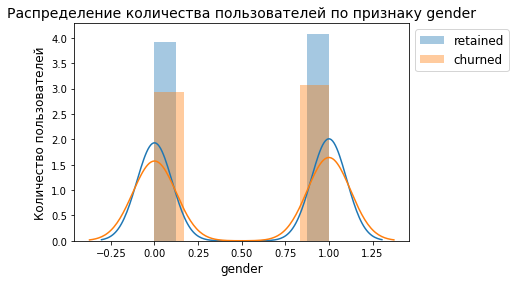

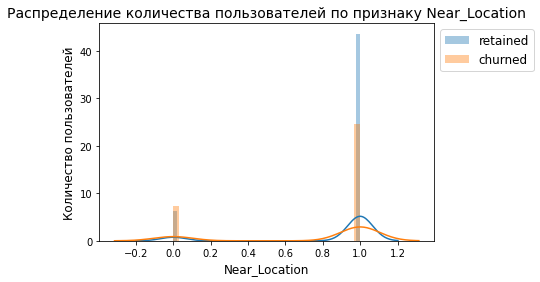

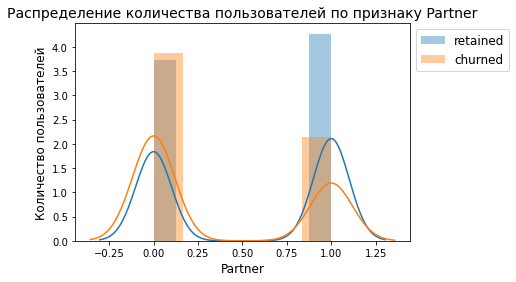

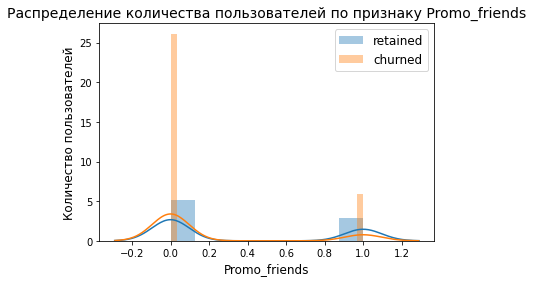

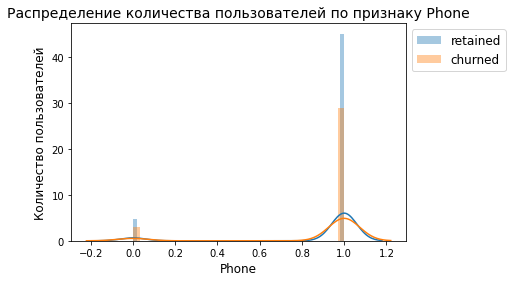

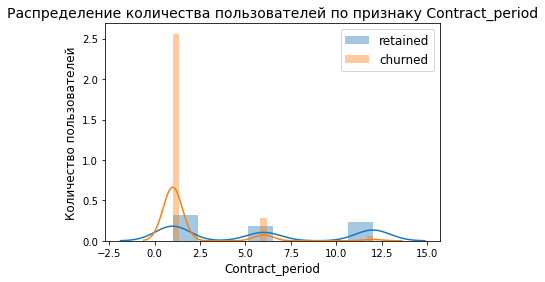

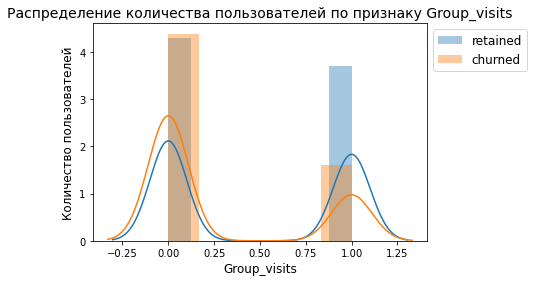

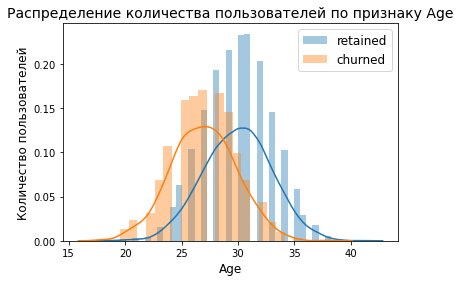

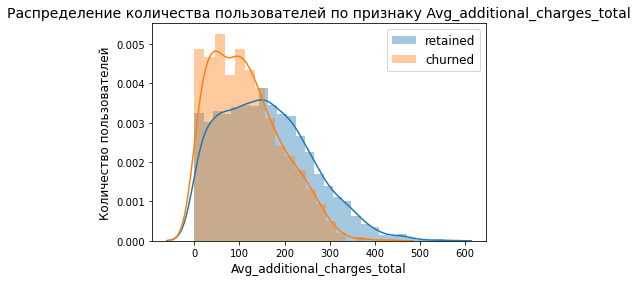

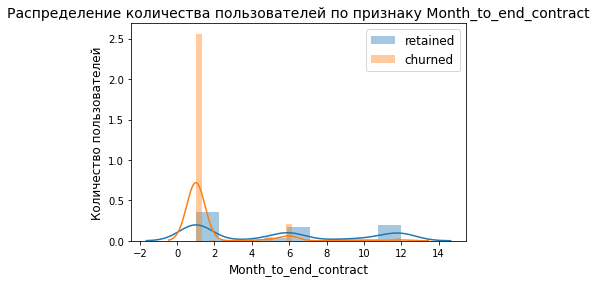

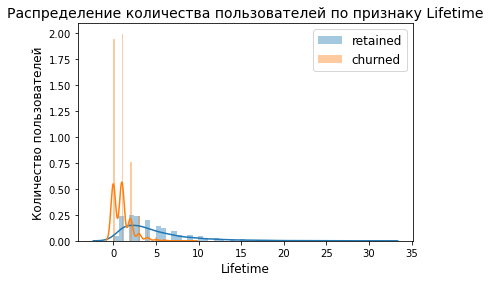

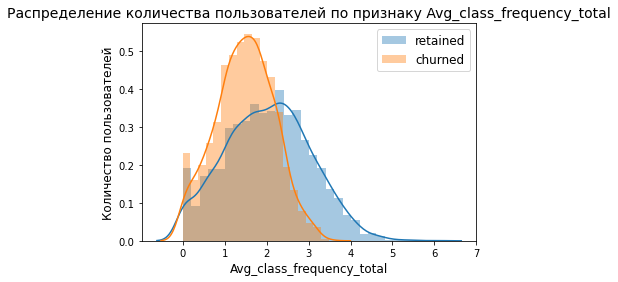

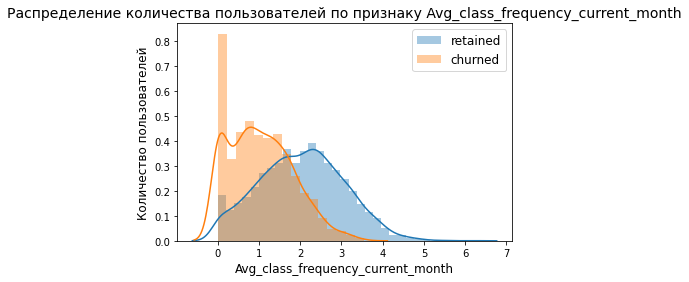

In [10]:
warnings.filterwarnings('ignore')
for column in gym.drop(columns='Churn').columns:
    plt.subplot()
    plt.title('Распределение количества пользователей по признаку ' + column, fontsize = 14)
    plt.xlabel('Значение признака', fontsize=12)
    plt.ylabel('Количество пользователей', fontsize=12)
    sns.distplot(gym_retained[column], label='retained')
    sns.distplot(gym_churned[column], label='churned')
    plt.grid(False)
    plt.legend(bbox_to_anchor=(1,1), fontsize=12)
    plt.show()

Количество удержанных клиентов равно 2939, что составляет 73.5 % от общего числа клиентов.

На основании гистограмм распределения признаков для удержанных клиентов можно выделить следущие факты:
  - количество "удержанных" мужчин примерно равно количеству "удержанных" женщин
  - большинство (более 2500 клиентов; около 85%) клиентов живут или работают или живут рядом с клубом, в том время как менее 500 - жвут или работают далеко от фитнес-клуба
  - количество клиентов, не являющихся сотрудниками компании-партнера клуба, примерно равно 1600 (54%), что чуть больше клиентов, являющихся сотрудниками-компаний партнеров (около 1400, или 46%)
  - около 66% клиентов (примерно 1900 человек) пришли не по акции "приведи акции", в том время как по данной акции пришли примерно 1000 человек
  - большинство клиентов (более 2500 человек, или более 85%) оставили свой телефонный номер
  - самой популярной продолжительностью контракта является 1 месяц: примерно половина (около 1300 человек, или 44%) клиентов заключают контракт на 1 месяц, контракт на 6 месяцев заключили около 700 человек (24%), на 12 месяцев - 900 (31%).
  - больше половины (примерно 1600 человек, или около 54%) не ходят на групповые занятие
  - около трети клиентов (примерно 1000 человек, 34%) в возрасте 30-32 лет, также около 1500 человек входят в возрастные группы 25-27 (примерно 400 человек, или 14%), 27-30 (примерно 700 человек, или 24%) и 32-35 лет (примерно 400 человек, или 14%)
  - большинство клиентов (примерно 2500, или 85%) платит за дополнительные услуги не более 300$
  - у примерно 1300 клиентов (44%) контракт истекает примерно через месяц. Также на гистограмме видны следующие пики: у примерно 600 человек (20%) контракт истекает через 6 месяцев, у примерно 700 человек (24%) - через 12 месяцев. Следовательно, как минимум 700 человек (около четверти клиентов) купили абонемент недавно.
  - большинство клиентов (около 2800 человек, или 95%) ходят в фитнес-клуб менее года
  - средняя частота посещений в неделю с начала действия абонемента приблизительно такая же, что и за предыдущих месяц: большинство клиентов посещают фитнес-клуб 2 раза в неделю (около 700 человек, 24%), также есть много клинетов, посещающих клуб 1 (400 человек, или 14%) или 3 раза (350 человек, 12%) в неделю.

Количество ушедших клиентов равно 1061, что составляет 26.5% от всех клиентов фитнес-клуба.

На основании гистограмм распределения признаков можно выделить следующие факты об ушедших клиентах:
  - число ушедших мужчин примерно равно числу ушедших женщин
  - из 1061 ушедшего клиента 800 живут или работают рядом с фитнес-клубом, что составляет 75%
  - около 700 ушедших клиентов (66%) не являются сотрудниками компаний-партнеров
  - более 800 ушедших клиентов (около 80%) пришли в фитнес-клуб не по акции "приведи друга"
  - почти 1000 человек (примерно 94%) оставили номер телефона
  - около 900 человек (85%) приоберли контракт на 1 месяц, около 100 (9%) - на 6 месяцев, около 50 человек (6%) - на 12 месяцев
  - около 750 человек (71%) не ходили на групповые занятия
  - большинство ушедших из клуба (около 270 человек, или 25%) были из возрастной группы 25-27 лет, также много ушедших клиентов находились в возрастной группе 27.5-30 лет (250 человек, или примерно 25%) и 22.5-25 лет (200 человек, или 19%)
  - большинство ушедших из клуба (около 900 человек, или 85%) платили менее 300$ за дополнительные услуги
  - у около 900 (85%) ушедших клиентов оставался 1 месяц по завершения контракта
  - около 800 ушедших клиентов (75%) посещали клуб не более 2 месяцев. Ушедших клиентов практически нет среди тех, кто посещал клуб более полугода
  - большинство ушедших клиентов (200 человек, или 19%) посещали фитнес-клуб 1.5 раза в неделю с начала действия абонемента, также 175 человек (16%) посещали фитнес-клуб 1 раз в неделю и примерно такое же количество клиентов - 3 раза в неделю
  - почти 200 человек (19%) не посещали фитнес-клуб в течение последнего месяца перед тем, как уйти из фитнес-клуба. Около 700 человек (66%) посещали занятия не более 2 раз в неделю в течение последнего месяца перед уходом из фитнес-клуба

In [11]:
def draw_corr(dataframe):
    corr_matrix = dataframe.corr() # матрица корреляций
    display(corr_matrix)
    plt.figure(figsize=(20, 17)) # размер диаграммы heatmap
    sns.heatmap(corr_matrix, annot=True, square=True) # построение heatmap на основании матрицы корреляций

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
gender,1.000000,0.006699,-0.010463,-0.005033,-0.008542,0.000502,0.017879,0.013807,-0.009334,-0.001281,0.013579,0.014620,0.009156,0.000708
Near_Location,0.006699,1.000000,-0.005119,0.210964,-0.015763,0.150233,0.154728,0.058358,0.040761,0.143961,0.070921,0.043127,0.062664,-0.128098
Partner,-0.010463,-0.005119,1.000000,0.451960,0.009970,0.306166,0.022710,0.047480,0.022941,0.294632,0.061229,0.024938,0.045561,-0.157986
Promo_friends,-0.005033,0.210964,0.451960,1.000000,0.001982,0.244552,0.120170,0.050113,0.036898,0.239553,0.072721,0.028063,0.053768,-0.162233
Phone,-0.008542,-0.015763,0.009970,0.001982,1.000000,-0.006893,-0.010099,-0.011403,0.009279,-0.011196,-0.018801,0.008340,0.013375,-0.001177
Contract_period,0.000502,0.150233,0.306166,0.244552,-0.006893,1.000000,0.169991,0.138249,0.111445,0.973064,0.170725,0.096211,0.159407,-0.389984
Group_visits,0.017879,0.154728,0.022710,0.120170,-0.010099,0.169991,1.000000,0.080934,0.032079,0.163703,0.075853,0.056695,0.075923,-0.175325
Age,0.013807,0.058358,0.047480,0.050113,-0.011403,0.138249,0.080934,1.000000,0.080240,0.134511,0.164693,0.119953,0.183095,-0.404735
Avg_additional_charges_total,-0.009334,0.040761,0.022941,0.036898,0.009279,0.111445,0.032079,0.080240,1.000000,0.113958,0.079028,0.044426,0.079570,-0.198697
Month_to_end_contract,-0.001281,0.143961,0.294632,0.239553,-0.011196,0.973064,0.163703,0.134511,0.113958,1.000000,0.161078,0.085387,0.147605,-0.381393


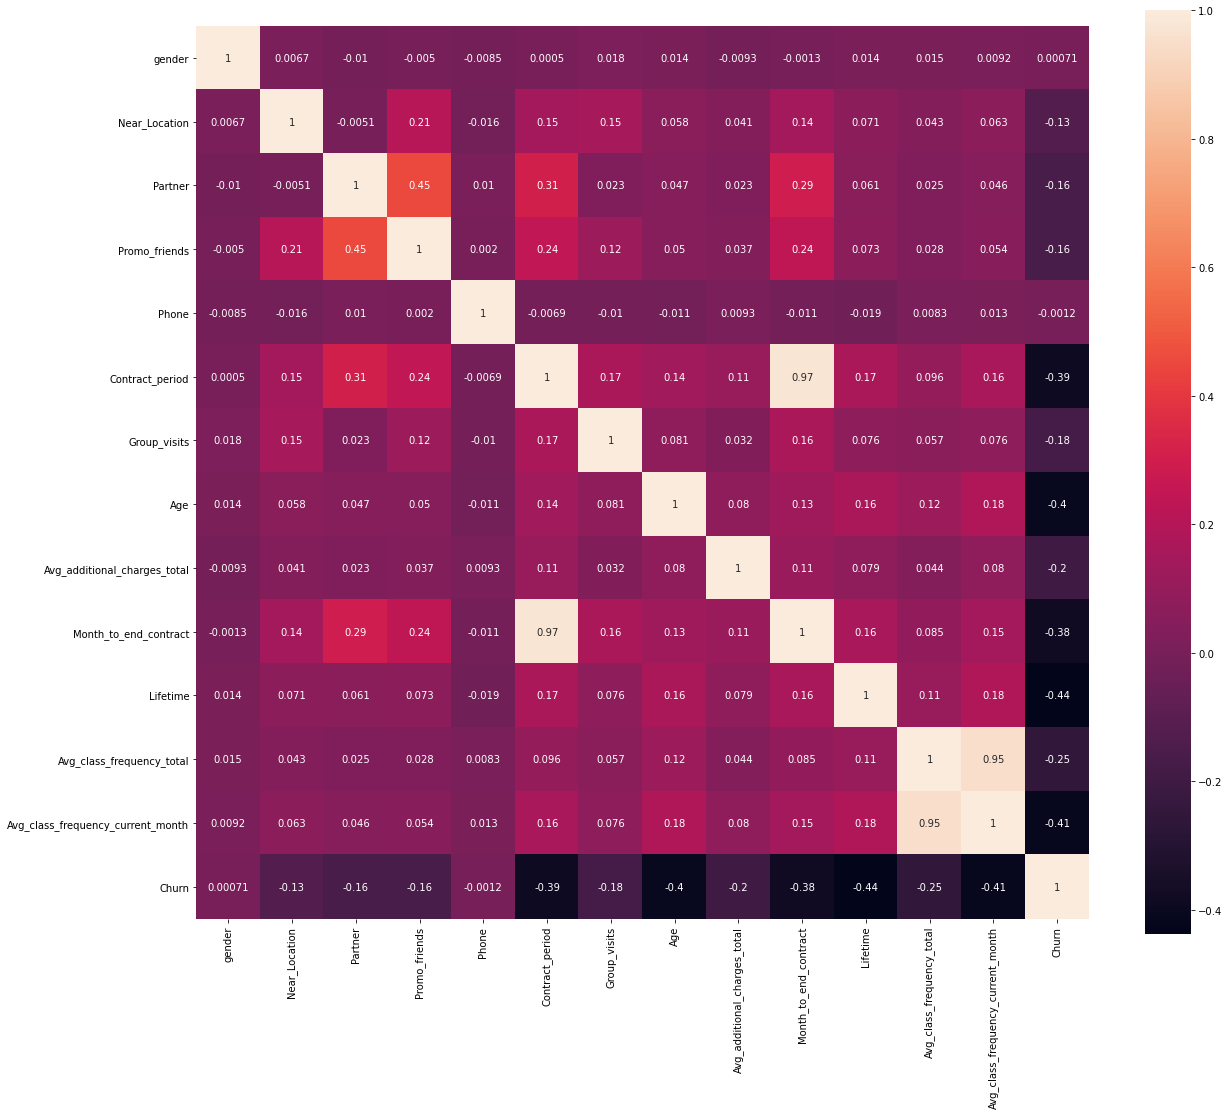

In [12]:
# матрица корреляций и heatmap для матрицы корреляций для всего датафрейма
draw_corr(gym)

На основании матрицы корреляций признаков и heatmap, построенной для этой матрицы, можно сделать вывод, что сильно скоррелированными признаками (признаки с коэффициентом корреляции 0.8 и больше) можно считать:
   - Month_to_end_contract (число месяцев до окончания абонемента) и Contract_period (длительность действия абонемент): коэффициент корреляции = 0.97
   - Avg_class_frequency_current_month (средняя частота посещений в неделю за предыдущий месяц) и Avg_class_frequency_total (средняя частота посещений в неделю за все время с начала действия абонемента): коэффициент корреляции = 0.95

Также менее сильная, но существенная корреляция наблюдается для признаков:
  - Promo_friends (клиент пришел по акции "приведи друга") и Partner (сотрудник компании-партнёра клуба): коэффициент корреляции = 0.45
  - Contract_period (длительность текущего действующего абонемента) и Partner: коэффициент корреляции = 0.31
  - Month_to_end_contract и Partner: коэффициент корреляции = 0.29
 
Существенная отрицательная корреляция наблюдяется для признаков:
  - Churn (факт оттока в текущем месяце) и Lifetime (время с момента первого обращения в фитнес-центр): коэффициент корреляции = -0.44
  - Churn и Avg_class_frequency_current_month: коэффициент корреляции = -0.41
  - Churn и Age (возраст клиента): коэффициент корреляции = -0.4
  - Churn и Contract_period: коэффициент корреляции = -0.39
  - Churn и Month_to_end_contract: коэффициент корреляции = 0.38

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month
gender,1.000000,0.004588,-0.017409,-0.002746,-0.008443,-0.002893,0.015434,0.014745,-0.013551,-0.005047,0.019150,0.018719,0.017506
Near_Location,0.004588,1.000000,-0.015871,0.198554,-0.013571,0.130844,0.147798,0.006876,0.023125,0.122438,0.022296,0.001698,0.000975
Partner,-0.017409,-0.015871,1.000000,0.455108,0.021220,0.294745,-0.011820,-0.011818,-0.006994,0.280882,-0.013123,-0.019247,-0.020797
Promo_friends,-0.002746,0.198554,0.455108,1.000000,-0.004713,0.217869,0.099610,-0.012915,-0.003494,0.212872,0.003754,-0.012794,-0.012416
Phone,-0.008443,-0.013571,0.021220,-0.004713,1.000000,-0.007959,0.000789,-0.011362,0.004559,-0.012660,-0.026664,0.018325,0.019386
Contract_period,-0.002893,0.130844,0.294745,0.217869,-0.007959,1.000000,0.126558,-0.021563,0.039649,0.967340,-0.001045,-0.006538,-0.005080
Group_visits,0.015434,0.147798,-0.011820,0.099610,0.000789,0.126558,1.000000,0.015875,0.001929,0.118517,0.002835,0.005587,0.003851
Age,0.014745,0.006876,-0.011818,-0.012915,-0.011362,-0.021563,0.015875,1.000000,-0.001919,-0.020407,-0.024132,0.023803,0.022948
Avg_additional_charges_total,-0.013551,0.023125,-0.006994,-0.003494,0.004559,0.039649,0.001929,-0.001919,1.000000,0.044765,-0.007366,-0.006934,-0.004487
Month_to_end_contract,-0.005047,0.122438,0.280882,0.212872,-0.012660,0.967340,0.118517,-0.020407,0.044765,1.000000,-0.008097,-0.016365,-0.015420


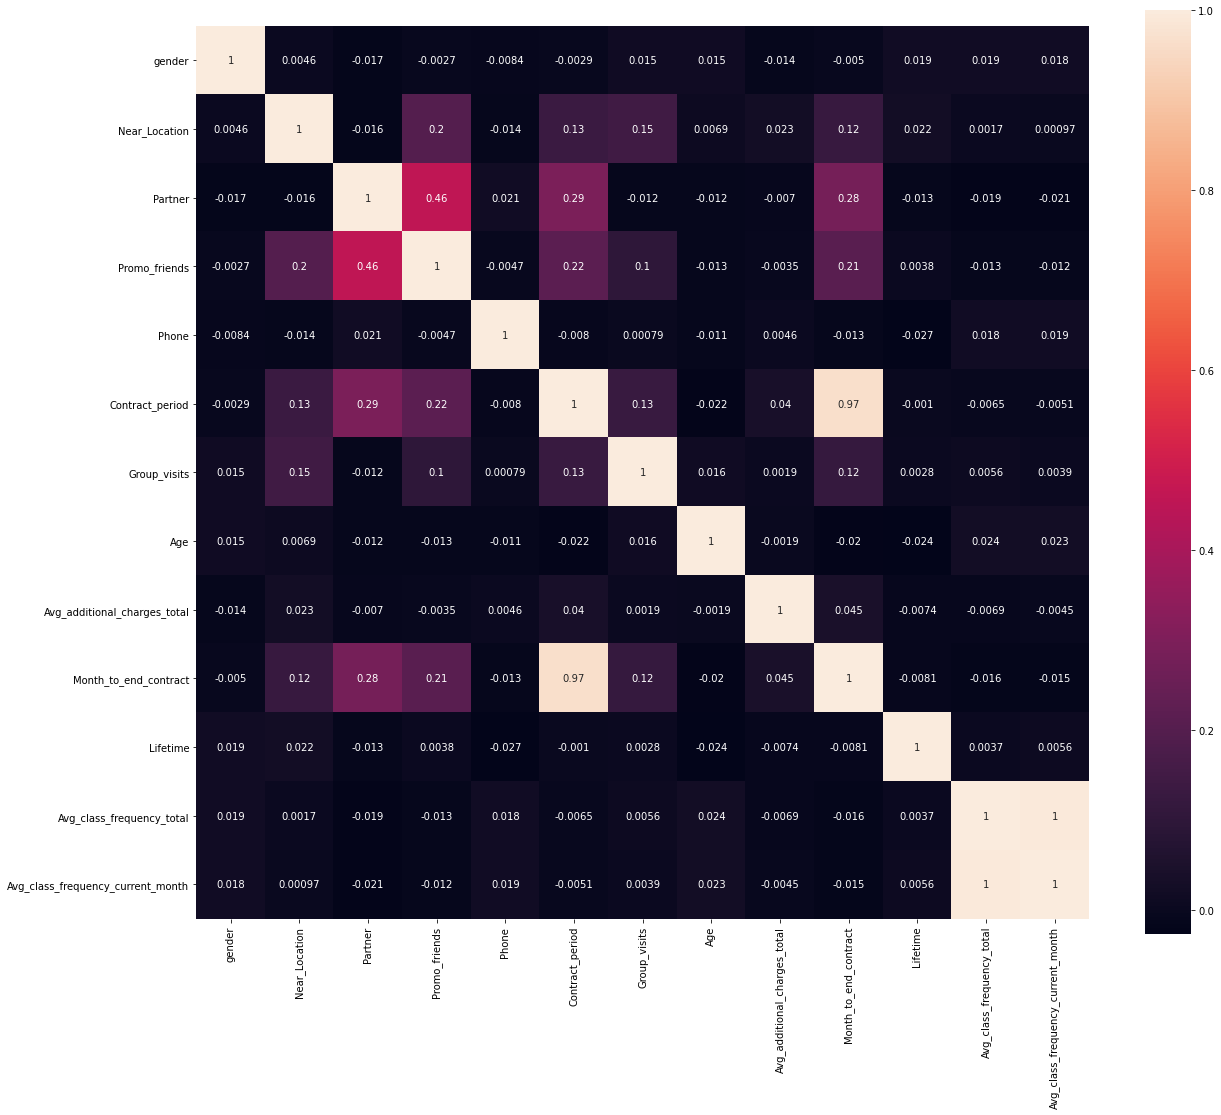

In [13]:
# матрица корреляций и heatmap для матрицы корреляций для датафрейма, содержащего инфомацию
# только об оставшихся клиентах
draw_corr(gym_retained)

Некоторая положительная корреляция наблюдается для признаков:

  - Promo_friends (клиент пришел по акции "приведи друга") и Partner (сотрудник компании-партнёра клуба): коэффициент корреляции = 0.46
  - Contract_period (длительность текущего действующего абонемента) и Partner: коэффициент корреляции = 0.29
  - Month_to_end_contract и Partner: коэффициент корреляции = 0.28

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month
gender,1.000000,0.011913,0.009509,-0.012723,-0.008811,0.023992,0.027271,0.017344,0.005232,0.022929,-0.008307,0.002240,-0.015462
Near_Location,0.011913,1.000000,-0.049416,0.197275,-0.021734,0.058915,0.111250,0.008065,-0.003562,0.061410,-0.008687,0.044960,0.040668
Partner,0.009509,-0.049416,1.000000,0.379864,-0.022625,0.172161,0.016582,-0.037490,-0.015331,0.167682,0.025813,0.001292,-0.025983
Promo_friends,-0.012723,0.197275,0.379864,1.000000,0.024085,0.091260,0.074777,-0.032778,0.041355,0.087734,-0.020081,-0.014362,-0.024533
Phone,-0.008811,-0.021734,-0.022625,0.024085,1.000000,-0.010393,-0.045483,-0.017676,0.026027,-0.015813,0.011553,-0.031635,-0.004533
Contract_period,0.023992,0.058915,0.172161,0.091260,-0.010393,1.000000,0.035279,-0.040035,0.026716,0.982937,0.017638,0.045401,0.025777
Group_visits,0.027271,0.111250,0.016582,0.074777,-0.045483,0.035279,1.000000,-0.004442,-0.022049,0.044576,-0.044651,0.050217,0.004890
Age,0.017344,0.008065,-0.037490,-0.032778,-0.017676,-0.040035,-0.004442,1.000000,0.006157,-0.049213,0.060986,0.011902,0.006559
Avg_additional_charges_total,0.005232,-0.003562,-0.015331,0.041355,0.026027,0.026716,-0.022049,0.006157,1.000000,0.027075,-0.035565,0.002112,0.006022
Month_to_end_contract,0.022929,0.061410,0.167682,0.087734,-0.015813,0.982937,0.044576,-0.049213,0.027075,1.000000,0.009349,0.036355,0.019289


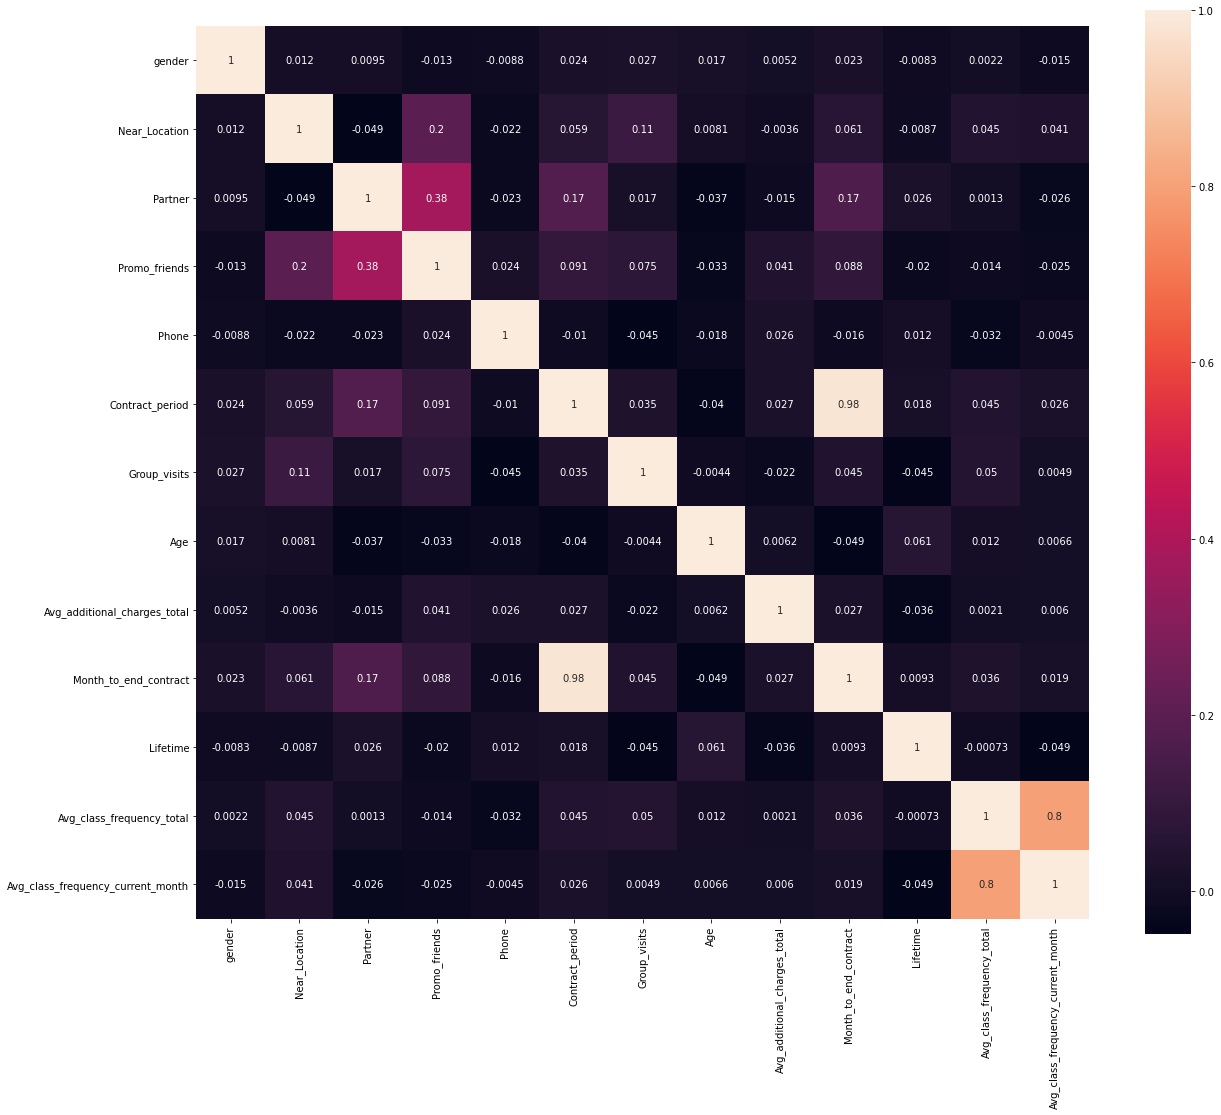

In [14]:
# матрица корреляций и heatmap для матрицы корреляций для датафрейма, содержащего инфомацию
# только об ушедших клиентах
draw_corr(gym_churned)

Некоторая положительная корреляция наблюдается для признаков:

  - Promo_friends (клиент пришел по акции "приведи друга") и Partner (сотрудник компании-партнёра клуба): коэффициент корреляции = 0.38
  - Contract_period (длительность текущего действующего абонемента) и Partner: коэффициент корреляции = 0.17
  - Month_to_end_contract и Partner: коэффициент корреляции = 0.17

**Выводы**

В датасете отсутствуют дубликаты и пропуски.

Ушедшие клиенты по сравнению с удержанными:
  - на 10% реже живут или работают рядом с фитнес-клубом (75% ушедших клиентов живут или работают с клубом, в то время как аналогичных показатель среди оставшихся клиентов равен 85%)
  - на 12% реже работают в компаниях-партнерах (34% ушедших клиента работают в компаниях-партнерах, 46% оставшихся клоиентов не являются сотрудниками компаний-партнеров)
  - на 41% больше заключают краткосрочные контракты (85% ушедших клиентов купили абонемент на 1 месяц, 44% оставшихся клиентов купили контракт на 1 месяц)
  - на 17% реже ходят на групповые занятия (71% ушедших клиентов не ходили на групповые занятия, в то время как 54% ушедших клиентов не ходили на групповые занятия)
  - уходят в течение первых двух месяцев с момента начала посещения клуба
  - в среднем ходят в фитнес-клуб реже по сравнению с оставшимися клиентами (ушедшие клиенты в основном ходили в фитнес-клуб 1.5 раза в неделю, в то время как оставшиеся - 2 раза в неделю с начала покупки абонемента)
  - в течение последнего месяца 19% ушедших клиентов не посещали фитнес-клуб вообще, а 66% посещали клуб не более 2 раз в неделю, в то время как удержанные клиенты ходят в фитнес-клуб 1-3 раза как при расчете с начала покупки абонемента, так и при расчете за последний месяц
  
Как для ушедших, так и для оставшихся клиентов наблюдается корреляция по признакам:
  - 'клиент пришел по акции "приведи друга"' и 'клиент является сотрудников компании-партнера клуба' (коэффициент корреляции = 0.46 для осташихся и 0.38 для ушедших клиентов): можно сделать вывод о том, что люди, работающие в компаниях-партнерах, приглашают своих коллег в фитнес-клуб
  - 'длительность текущего действующего абонемента' и 'сотрудник компании-партнера клуба' (коэффициент корреляции = 0.29 для оставшихся и 0.17 для ушедших клиентов): компании могут предлагать сотрудникам абонементы определенной длительности
  - 'срок до окончания текущего действующего абонемента' и 'сотрудник компании-партнера клуба' (коэффициент корреляции = 0.28 для оставшихся и 0.17 для ушедших клиентов)
  
Отток клиентов отрицательно коррелирует со следующими признаками (чем больше значение признака, тем ниже отток):
  - время с момента первого обращения в фитнес-центр (коэффициент корреляции = -0.44)
  - средняя частота посещений в неделю за все время с начала действия абонемента (коэффициент корреляции = -0.41)
  - возраст (коэффициент корреляции = -0.4)
  - длительность текущего действующего абонемента (коэффициент корреляции = -0.39)
  - срок до окончания текущего действующего абонемента (коэффициент корреляции = -0.38)

## Построение модели прогнозирования оттока клиентов

In [15]:
# формирование матрицы признаков
X = gym.drop('Churn', axis=1)
X.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078


In [16]:
# значения целевой переменной
y = gym['Churn']

In [17]:
# разделение выборки на обучающую и валидационную
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [18]:
# стандартизация данных
scaler = StandardScaler()
scaler.fit_transform(X_train)
X_train_st = scaler.transform(X_train) 
X_test_st = scaler.transform(X_test)

In [19]:
# функция, создающая матрицу корреляций
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [26]:
# функция, выводящая метрики для модели
def calc_metrics(y_test, y_pred, y_proba, model):
    print('Метрики классификации для модели', model)
    print('Accuracy: {:.2f}, Precision: {:.2f}, Recall: {:.2f}, F1: {:.2f}, ROC_AUC: {:.2f}'.
         format(
             accuracy_score(y_test, y_pred), 
             precision_score(y_test, y_pred),
             recall_score(y_test, y_pred),
             f1_score(y_test, y_pred),
             roc_auc_score(y_test, y_proba)
             )
         )
    # отрисовка матрицы корреляций
    plt.rc('font')

    cnf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 8))
    plt.grid(False)
    plot_confusion_matrix(cnf_matrix, classes=['Non-churned', 'Churned'],
                          title='Матрица корреляций')
    plt.show()
    
    # отрисовка ROC-кривой
    sns.set(font_scale=1.5)
    sns.set_color_codes("muted")

    plt.figure(figsize=(10, 8))
    fpr, tpr, thresholds = roc_curve(y_test, y_proba, pos_label=1)
    lw = 2
    plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
    plt.plot([0, 1], [0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC кривая')
    plt.show()

Метрики классификации для модели логичестической регресии
Accuracy: 0.94, Precision: 0.90, Recall: 0.85, F1: 0.87, ROC_AUC: 0.98
Confusion matrix, without normalization
[[567  21]
 [ 31 181]]


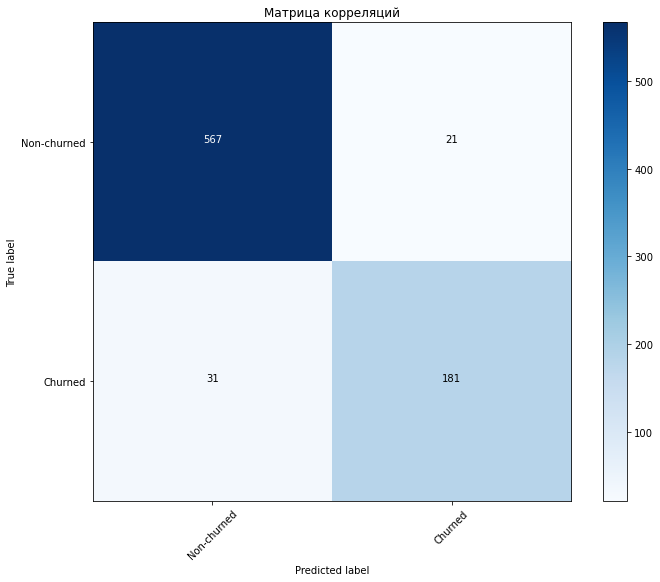

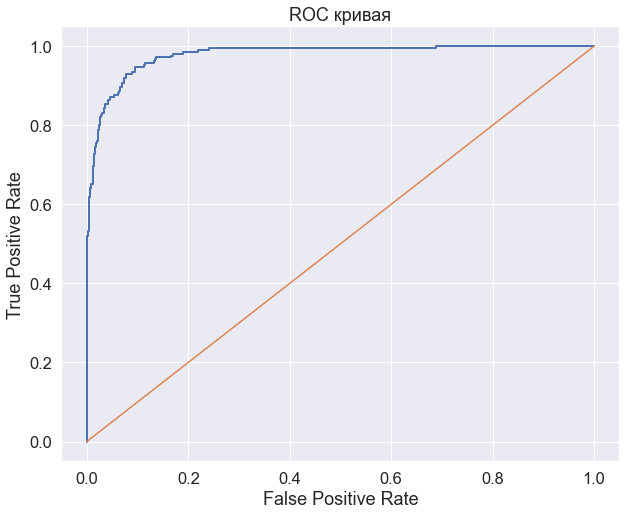

In [27]:
# обучение модели на train-выборке с помощью модели логичестической регресии
warnings.filterwarnings('ignore')
log_model = LogisticRegression(random_state=0)
log_model.fit(X_train_st, y_train)
log_predictions = log_model.predict(X_test_st)
log_probabilities = log_model.predict_proba(X_test_st)[:,1]
calc_metrics(y_test, log_predictions, log_probabilities, 'логичестической регресии')

Метрики классификации для модели случайного леса
Accuracy: 0.88, Precision: 0.88, Recall: 0.63, F1: 0.74, ROC_AUC: 0.90
Confusion matrix, without normalization
[[570  18]
 [ 78 134]]


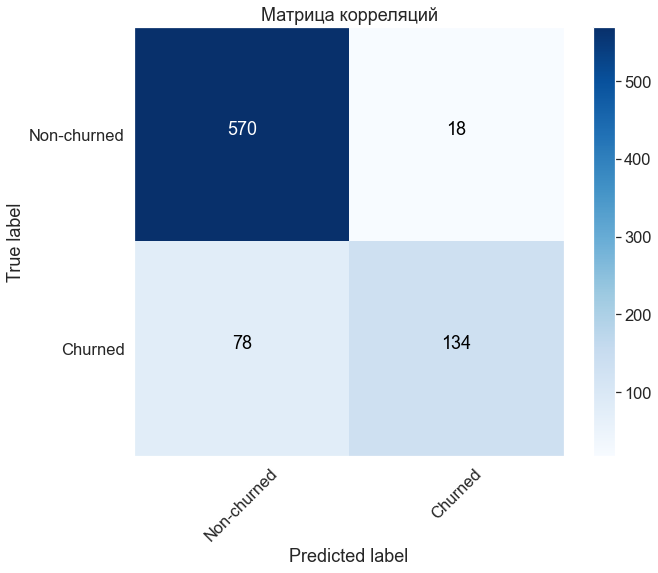

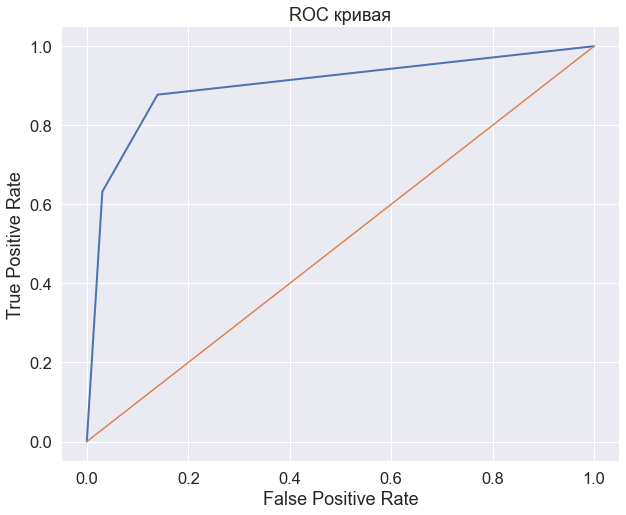

In [28]:
# обучение модели на train-выборке с помощью модели случайного леса
rf_model = RandomForestClassifier(n_estimators=2, random_state=0)
rf_model.fit(X_train_st, y_train)
rf_predictions = rf_model.predict(X_test_st)
rf_probabilities = rf_model.predict_proba(X_test_st)[:,1]
calc_metrics(y_test, rf_predictions, rf_probabilities, 'случайного леса')

**Вывод**

Модель логичестической регрессии показывает лучшие результаты по сравнению с моделью случайного леса по метриками Accuracy (0.92 у логической регрессии, 0.88 у случайного леса), Recall (0.83 - логическая регрессия, 0.64 - случайный лес), F1 (0.84 - логистическая регрессия, 0.73 - случайный лес) и ROC_AUC (0.97 - логистическая регрессия, 0.89 - случайный лес). У модели случайного леса по сравнению с моделью логистической регрессии лучше результаты по метрикам Precision(0.85 - логистическая регрессия, 0.86 - случайный лес).

Модель логической регрессии по сравнению с моделью случайного леса показывает более точные результаты согласно большинству метрик. Следовательно, модель логистической регрессии лучше подходит для прогнозирования оттока клиентов, чем модель случайного леса.

## Кластеризация клиентов

In [29]:
# стандартизация данных
sc = StandardScaler()
x_sc = sc.fit_transform(gym)

In [30]:
linked = linkage(x_sc, method='ward') # таблица связок между объектами

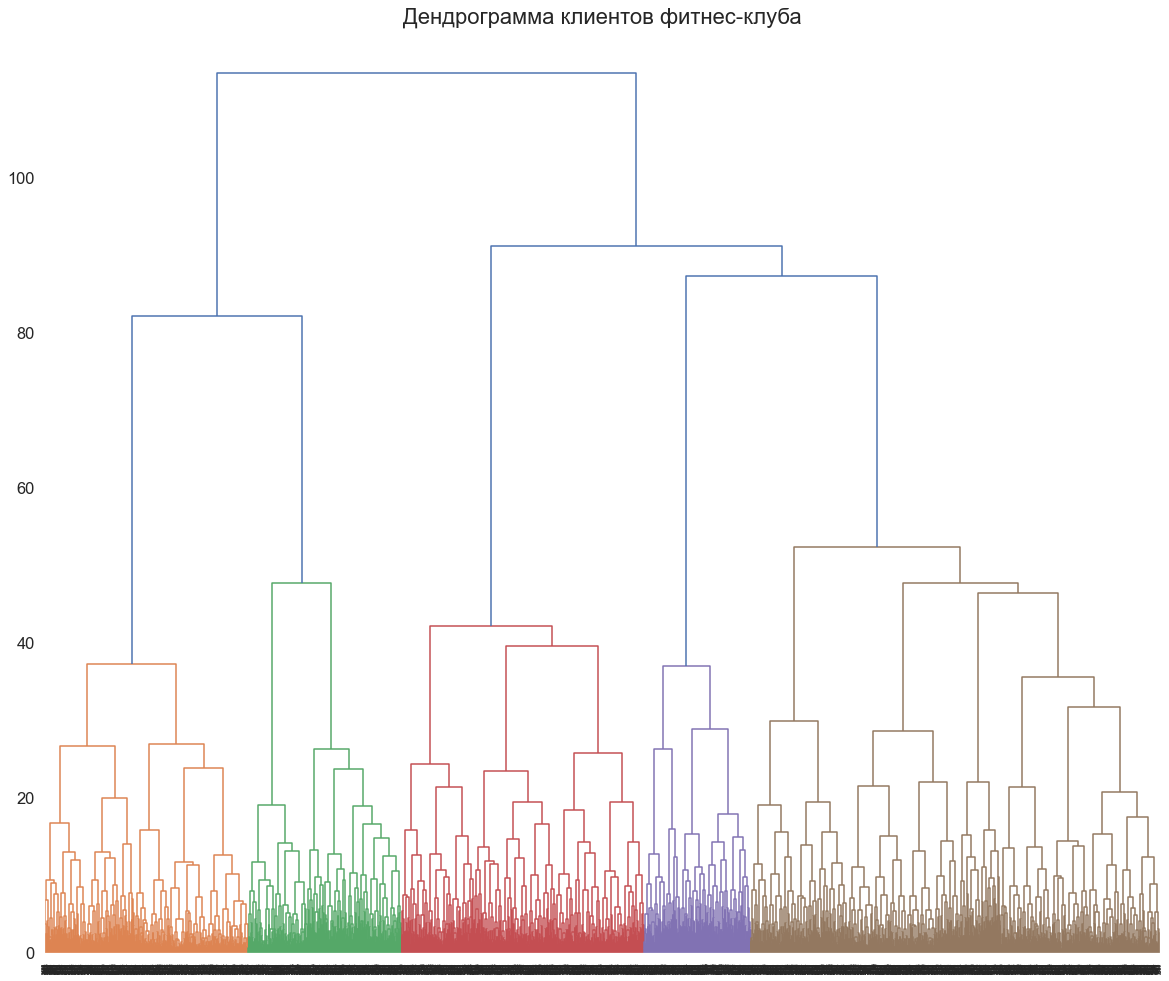

In [31]:
# отрисовка дендрограммы
plt.figure(figsize=(20, 17))
dendrogram(linked, orientation='top')
plt.title('Дендрограмма клиентов фитнес-клуба', fontsize=22)
plt.show()

In [32]:
# задается модель k_means с числом кластеров равным 5 и фиксируется значение random_state
km = KMeans(n_clusters=5, random_state=0)

In [33]:
# прогнозируемые кластеры для наблюдений
labels = km.fit_predict(x_sc)

# сохранение меток кластера в столбец датасета
gym['cluster'] = labels

# переименование кластеров
gym.loc[gym['cluster'] == 0, 'cluster'] = 'cluster_1'
gym.loc[gym['cluster'] == 1, 'cluster'] = 'cluster_2'
gym.loc[gym['cluster'] == 2, 'cluster'] = 'cluster_3'
gym.loc[gym['cluster'] == 3, 'cluster'] = 'cluster_4'
gym.loc[gym['cluster'] == 4, 'cluster'] = 'cluster_5'

gym.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn,cluster
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0,cluster_5
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0,cluster_2
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0,cluster_4
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0,cluster_2
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0,cluster_5


In [34]:
# средние значения признаков по кластерам
gym.groupby('cluster').mean()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
cluster,,,,,,,,,,,,,,
cluster_1,0.503676,0.000000,0.459559,0.075368,0.917279,2.069853,0.211397,28.522059,132.741216,1.950368,2.757353,1.706629,1.515890,0.450368
cluster_2,0.492829,0.936115,0.764016,0.534550,0.919166,10.447197,0.516297,29.962190,161.853561,9.477184,4.833116,2.788103,2.786919,0.007823
cluster_3,0.507917,1.000000,0.323995,0.213155,0.903776,1.546894,0.287454,26.926918,113.173051,1.500609,1.031669,1.449720,1.037592,0.961023
cluster_4,0.521186,0.996610,0.282203,0.208475,0.904237,1.882203,0.452542,30.237288,157.988625,1.794915,4.923729,2.203432,2.207359,0.003390
cluster_5,0.518895,0.968023,0.744186,0.526163,0.873547,8.859012,0.534884,29.728198,162.907495,8.155523,4.411337,0.957744,0.943967,0.024709


Кластерами с низким оттоком клиентов можно назвать кластеры 2, 4 и 5: 0.8% оттока, 0.3% и 2.5%, соответственно. Кластерами в высоким оттоком можно назвать кластеры 1 и 3: 45% оттока и 96%, соответственно.

Клиенты распределены по полу примерно одинаково во всех кластерах.

**Кластер 1:**

  - **45% клиентов из этого кластера уходят из фитнес-клуба - значительный отток клиентов**
  - клиенты из этого кластера живут или работают далеко от фитнес-клуба
  - 46% клиентов являются сотрудниками компании-партнера
  - 7.5% клиентов пришли по акции "приведи друга"
  - 92% оставили свой номер телефона
  - в среднем клиенты покупают абонемент на 2 месяца
  - 21% клиентов посещают групповые занятия
  - средний возраст в кластере 28.5 лет
  - в среднем пользователи платят за дополнительные услуги 132$
  - в среднем у клиентов остается чуть менее 2 месяцев до окончания действия абонемента
  - пользователи ходят в клуб 2.8 месяца
  - в среднем клиенты ходят в фитнес-клуб 1.7 раза в неделю, считая с начала действия абонемента
  - клиенты ходят в фитнес-клуб в среднем 1.5 раз в неделю, считая за прошлый месяц
  
**Кластер 2:**

  - **0.78% клиентов из этого кластера уходят из фитнес-клуба - низкий отток клиентов**
  - 94% клиентов живут рядом с фитнес-клубом
  - 76% работают в компаниях-партнерах
  - 53% пришли по акции "приведи друга"
  - 92% оставили номер телефона
  - в среднем клиенты покупают абонемент на 10.5 месяцев - **наибольшая длина абонемента среди кластеров**
  - 52% ходят на групповые занятия
  - средний возраст - 30 лет
  - в среднем платят 162$ за дополнительные услуги в месяц
  - абонемент в среднем заканчивается через 9.5 месяцев
  - клиенты в среднем посещают фитнес-клуб в течении 4.8 месяцев
  - клиенты ходят в фитнес-клуб 2.8 раза в неделю - **наибольшая частота занятий в неделю**
  - частота посещения в месяц не снизилась на протяжении последнего месяца
  
**Кластер 3:**

  - **96% клиентов из этого кластера уходят из фитнес-клуба - наибольший отток клиентов**
  - все клиенты живут или работают рядом с клубом
  - 32% являются сотрудниками компаний-партнеров
  - 21% пришел по акции "приведи друга"
  - 90% оставили номер телефона
  - средняя продолжительность абонемента - 1.5 месяца - **наименьшая средняя продолжительность абонемента**
  - 29% посещают групповые занятия
  - средний возраст - 27 лет
  - в среднем клиенты платят за дополнительные услуги 113$ в месяц
  - абонемент в среднем заканчивается через 1.5 месяца
  - клиенты в среднем пришли в клуб 1 месяц назад
  - клиенты ходят в фитнес-клуб в среднем 1.4 раза в неделю, считая с начала действия абонемента - **наименьшая частота занятий
  среди всех кластеров**
  - клиенты ходят в фитнес-клуб в среднем 1 раз в неделю, считая за прошлый месяц - **наименьшая частота занятий среди всех кластеров, также частота занятий в этом кластере значительно снизилась за последний месяц**
  
**Кластер 4:**

  - **0.33% клиентов из этого кластера уходят из фитнес-клуба - наименьший отток клиентов**
  - 99.6% клиентов живут или работают рядом с фитнес-клубом
  - 28% являются сотрудниками компаний-партнеров - **наименьший процент во всех кластерах**
  - 21% пришел по акции "приведи друга" - **наименьший процент во всех кластерах**
  - 90% оставили номер телефона
  - средняя продолжительность абонемента - 1.9 месяца - **короткий срок действия абонемента**
  - 45% посещают групповые занятия
  - средний возраст - 30 лет - **самый высокий средний возраст во всех кластерах**
  - в среднем клиенты платят за дополнительные услуги 158$ в месяц 
  - абонемент в среднем заканчивается через 1.8 месяца
  - клиенты в среднем пришли в клуб 5 месяцев назад
  - клиенты ходят в фитнес-клуб в среднем 2.2 раза в неделю, считая с начала действия абонемента
  - клиенты ходят в фитнес-клуб в среднем 2.2 раз в неделю, считая за прошлый месяц - **частота занятий в этом кластере не снизилась на протяжении последнего месяца**
  
**Кластер 5:**

  - **2.5% клиентов из этого кластера уходят из фитнес-клуба - низкий отток клиентов**
  - 97% клиентов живут или работают рядом с фитнес-клубом
  - 74% являются сотрудниками компаний-партнеров
  - 53% пришели по акции "приведи друга" - **наибольший процент клиентов пришедших по акции** 
  - 87% оставили номер телефона
  - средняя продолжительность абонемента - 8.9 месяца
  - 53% посещают групповые занятия - **наибольший процент клиентов, посещающих групповые занятия среди кластеров**
  - средний возраст - 29.7 лет 
  - в среднем клиенты платят за дополнительные услуги 163$ в месяц - **кластер, платящий набольшую сумма за доп услуги**
  - абонемент в среднем заканчивается через 8.2 месяца
  - клиенты в среднем пришли в клуб 4.4 месяцев назад
  - клиенты ходят в фитнес-клуб в среднем 0.96 раза в неделю, считая с начала действия абонемента
  - клиенты ходят в фитнес-клуб в среднем 0.94 раз в неделю, считая за прошлый месяц - **частота занятий в этом кластере не снизилась на протяжении последнего месяца**
  

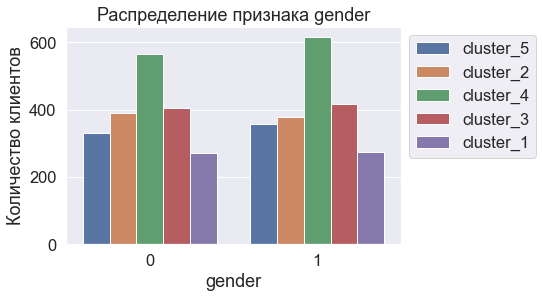

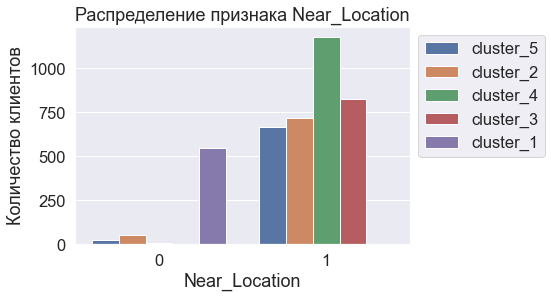

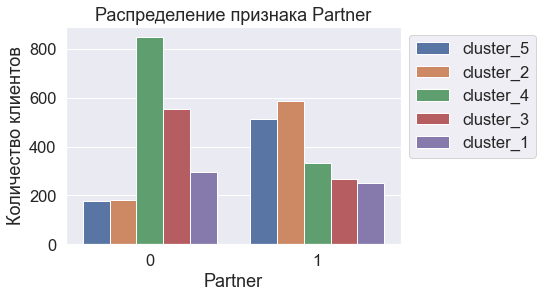

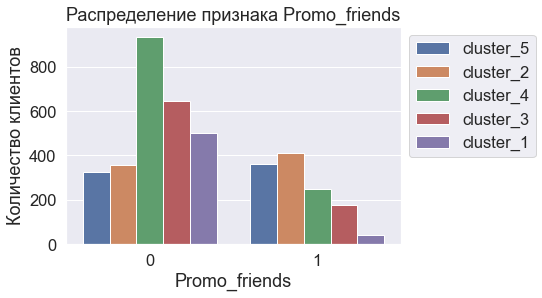

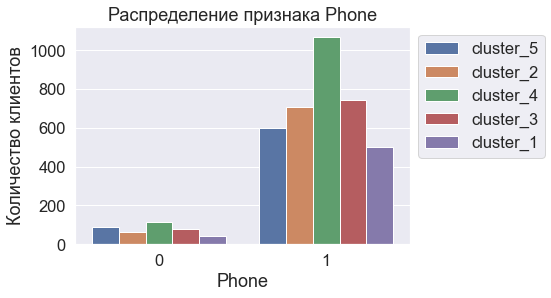

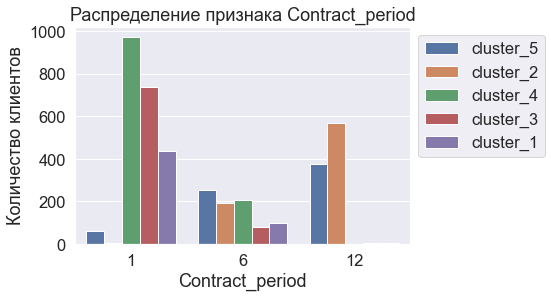

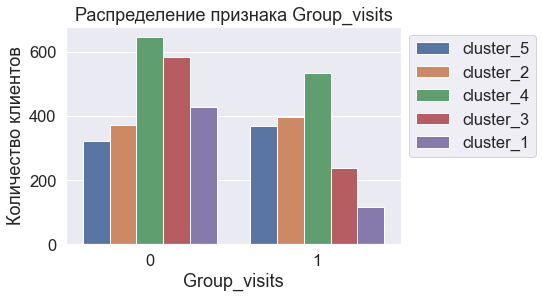

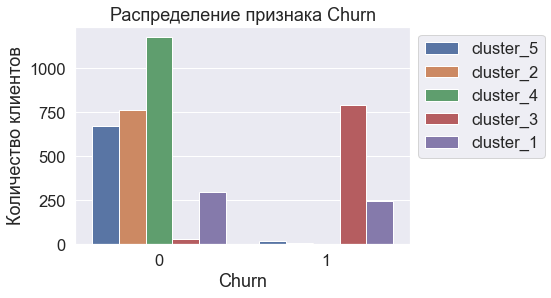

In [35]:
# список признаков дискретных величин
discrete_features = ['gender', 'Near_Location', 'Partner', 'Promo_friends', 'Phone', 'Contract_period', 'Group_visits', 'Churn']
fig, ax = plt.subplots()
for feature in discrete_features:
    ax = sns.countplot(x=feature, data=gym, hue='cluster') # подсчет количества клиентов для признака в разбивке по кластерам
    ax.set_title('Распределение признака ' + feature)
    ax.set_ylabel('Количество клиентов')
    plt.legend(bbox_to_anchor=(1,1))
    plt.show()

По распределению признаков для дискретных величин можно выделить следующие признаки:
  - клиенты распределены примерно одинаково по половому признаку во всех кластерах
  - **удаленность фитнес-клуба от дома или работы** влияет на отток клиентов: клиенты из кластеров с самыми низким оттоком (2, 4 и 5) живут или работают близко к фитнес-клубу. Клиенты из кластера 3, с самым высоким оттоком, также живут или работают близко к клубу, однако в кластере 1, также характеризующимся высоким оттоком, все клиенты живут или работают далеко от фитнес-клуба.
  - факт того, что **клиент является сотрудником компании-партнера** влияет на факт оттока: в кластерах с низким оттоком (2 и 5) большинство клиентов являются сотрудниками компаний-партнеров. Однако в кластере 4, где отток также низкий, клиентов из компаний-партнеров меньше, чем не из подобных компаний, также как и в кластере 3 с высоким оттоком. В кластере 1 с высоким уровнем оттока доли сотрудников и не-сотрудников компаний-партнеров примерно равны
  - факт того, что **клиент пришел по акции "приведи друга"** влиет на отток клиентов: примерно половина клиентов из кластеров 2 и 5 пришла по данной акции. Однако в кластере 4 таких клиентов меньше трети, хотя во всех трех кластерах наблюдается низкий отток клиентов. Для кластеров 1 и 3 с высоким оттоком клиентов характерна низкая доля тех, кто пришел по акции
  - факт оставления клиентом номера телефона не влияет на отток клиентов: во всех кластерах примерно равные доли клиентов оставили свой номер телефона
  - **срок действия абонемента** может влиять на отток клиентов: короткие абонементы на 1 месяц являются самыми популярными в кластерах 1 и 3 с высоким оттоком. Однако абонементы на 1 месяц характерны и для кластера 4 с низким оттоком клиентов. Для двух других кластеров с низким оттоком более характерна покупка абонементов на 6 и 12 месяцев, чем на 1 месяц
  - **факт посещения групповых занятий** влияет на отток клиентов: в кластерах 2 и 5 примерно половина клиентов посещает групповые занятия, в кластере 4 - чуть меньше половины. Однако, в кластерах 1 и 3 групповые занятия посещают не больше трети клиентов.
  - отток клиентов наиболее сильный в кластере 3 (уходят почти все клиенты) и кластере 1 (уходит чуть меньше половины клиентов). Клиенты из кластеров 2, 4 и 5 практически не уходят

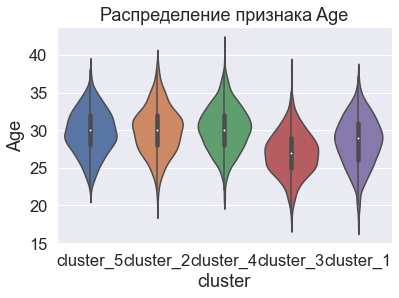

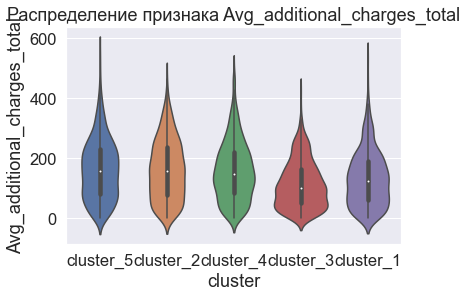

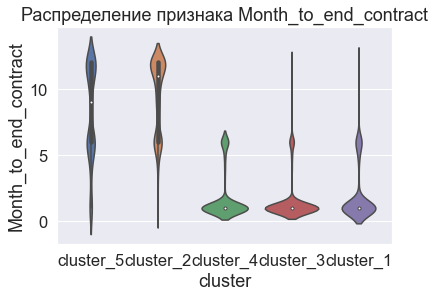

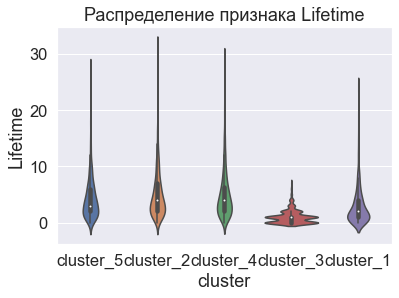

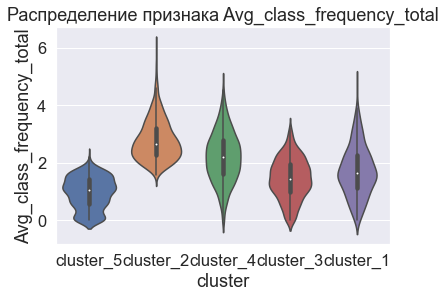

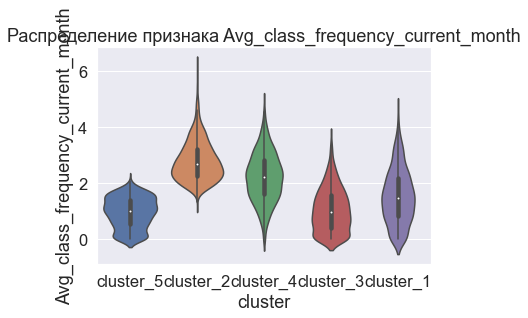

In [36]:
# распределение признаков для непрерывных величин
continuous_features = ['Age', 'Avg_additional_charges_total', 'Month_to_end_contract', 'Lifetime', 'Avg_class_frequency_total',
                      'Avg_class_frequency_current_month']
for feature in continuous_features:
    ax = sns.violinplot(x=gym['cluster'], y=gym[feature]) # отрисовка violin plot для непрервных признаков в разбивке по кластерам
    ax.set_title('Распределение признака ' + feature)
    plt.show()

По распределению признаков с непрервными значения можно выделить сказать следующее:
  - **возраст** клиента влияет на факт оттока: клиенты в кластерах 2, 4 и 5 имеют одинаковый средний возраст - 30 лет, кластере 3 средний возраст ниже примерно на 3 года. В кластере 4, где уходит примерно половина клиентов, средний возраст ниже, чем в кластерах 2, 4 и 5, но выше чем в кластере 3. Форма распределения во всех кластерах примерно одинакова.
  - **сумма, которую клиент платит в течение месяца за дополнительные услуги** влияет на отток: в кластерах 2, 4 и 5 с низким оттоком клиенты платят больше денег за дополнительные услуги по сравнению с кластерами 1 и 4 с высоким оттоком. Также распределение клиентов в кластере 3 показывает, что 75% клиентов платят меньше 150 долларов в месяц, также таких клиентов много в кластере 1. В это же время распределения в кластерах 2, 4 и 5 показывают что около полвины клиентов платят больше 150 долларов
  - число месяцев до кончания абонемента не влияет на отток клиентов: в кластерах с низким оттоком клиентов 2 и 5 абонемент у большинства пользователей заканчивается не раньше, чем через полгода (по форме распределений в обоих кластерах видно, что у распределений есть два пика - 6 и 12 месяцев, при этом пик на 11 месяцах является наибольшим). В это же время как в кластере в низким оттоком 4 форма распределеная наиболее похожа на формы распределений для кластеров с высоким оттоком 1 и 3. Во всех трех кластерах пик распределения приходится на 1 месяц до окончания абонемента
  - **лайфтайм** клиента влияет на вероятность оттока: клиенты из кластеров 2, 4 и 5 с низким оттоком имеют больший лайтфайм (в кластерах 2, 4 и 5 распределение вытянутое: пик распределения приходится на трёхмесячный лайфтайм, однако встречается довольно много клиентов с лайфтаймом в 6 месяцев и более) по сравнению с клиентами из кластера 3 с самым высоким оттоком (распределение клиентов в кластере 3 "сжатое": у практически всех клиентов лайфтайм составляет 3 месяца и меньше). Также в кластере 3 практически отсутствуют клиенты с лайфтаймом больше полугода, хотя такие клиенты присутствуют во всех остальных кластерах. Лайфтайм клиентов в кластере 1 (половина клиентов уходит) ниже, чем в кластерах 2, 4 и 5, но выше чем в кластере 3. По форме распределения видно, что в кластере 1 около 75% клиентов в этом кластере имеют лайфтайм не более 4 месяцев
  - частота занятий в неделю не влиет на отток клиентов: в кластерах 1 и 3 с высоким оттоком частота занятий ниже, чем в кластерах 2 и 4 с низким оттоком. Однако самая низкая частота походом в фитнес-клуб наблюдается в кластере 5 (в среднем 1 раз в неделю), хотя этот кластер характеризуется низким оттоком клиентов
  - **изменение частоты занятий в неделю при расчете за последний месяц** влияет на отток клиентов: в кластерах с низким оттоком клиентов число занятий за последний месяц не изменилось по сравнению с числом занятий, рассчитанных с момента покупли абонемента. Однако в кластере 3 число занятий за последний месяц снизилось и по форме распределения также видно, что больше клиентов в этом кластере стало совершать меньше походов в фитнес-клуб

In [37]:
# доля оттока клиентов по кластерам
cluster_churn = gym.groupby('cluster')['Churn'].\
                agg(['sum', 'count']).\
                rename(columns={'sum':'churned_clients', 'count':'len_cluster'})
# столбец с информацией о доле ушедших клиентов
cluster_churn['churned_portion'] = round(cluster_churn['churned_clients']/cluster_churn['len_cluster'], 3)
# столбец с информацией о проценте ушедших клиентов
cluster_churn['churned_percent'] = cluster_churn['churned_portion'] * 100
cluster_churn

,churned_clients,len_cluster,churned_portion,churned_percent
cluster,,,,
cluster_1,245,544,0.450,45.0
cluster_2,6,767,0.008,0.8
cluster_3,789,821,0.961,96.1
cluster_4,4,1180,0.003,0.3
cluster_5,17,688,0.025,2.5


Наибольший отток клиентов наблюдается в кластере 2: 96.1% клиентов из этого кластера перестали посещать фитнес-клуб. Наименьший отток клиентов наблюдается в кластерах 3 (ушли 3% клиентов) и 1 (ушел 1% клиентов).

**Вывод**

Было выделено 5 кластеров: кластеры 2, 4 и 5 имеют низкий процент оттока, кластеры 1 и 3 имеют высокий процент оттока.

Кластер 1 имеет высокий процент оттока (уходят 45% клиентов). Небольшая доля клиентов (21%) из этого кластера ходит на групповые занятия; меньше половины являюся сотрудниками компаний-партнеров; меньше 10% пришли по акции "приведи друга"; пользователи в основном ходят в клуб менее 3 месяцев; в кластере много тех, кто приобретает документ на 1 месяц; частота занятий для пользователей из этого кластера несколько снизилась за последний месяц; ; клиенты посещают фитнес-клуб в основном 1-2 раза в неделю.

Кластер 2 имеет низкий процент оттока (0.78%). Больше половины клиентов являются сотрудниками компаний-партнеров и/или пришли по акции "приведи друга"; для клиентов из этого кластера характеры абонементы на более продолжительный срок (6 или 12 месяцев); для кластера характерен продолжительный лайфтайм; больше половины клиентов ходят на групповые занятия; в среднем клиенты платят более 160 долларов за дополнительные услуги в месяц; частота занятий не снизилась на протяжении последнего месяца; клиенты посещают фитнес-клуб в основном 2-3 раза в неделю или чаще, при этом практически никто в этом кластере не посещает фитнес-клуб 1 раз в неделю или реже.

Кластер 3 имеет наибольший отток клиентов (96%). В данном кластере мало тех, кто пришел из компаний-партнеров (32%) и тех, кто пришел по акции "приведи друга" (21%); очень много клиентов, которые приобрели абонемент на 1 месяц; меньше трети клиентоы в этом кластере посещают групповые занятия; клиенты имеют короткий средний лайфтайм (1 месяц); клиенты в этом кластере платят меньше по сравнению с другими кластерами за дополнительные услуги; в этом кластере отмечается значительное снижение частоты занятий за последний месяц.

Кластер 4 имеет самый низкий отток клиентов (0.33%). Для этого кластера характерен малый процент клиентов из компаний партнеров (28%) и тех, кто пришел по акции "приведи друга" (21%); в кластере много тех, кто купил абонемент на 1 месяц; в среднем клиенты из этого кластера платят 158 долларов за дополнительные услуги в месяц; частота занятий для клиентов этого кластера не снизилась в последний месяц; большинство клиентов ходят в фитнес-клуб 1-4 раза в неделю.

Кластер 5 имеет отток 2.5%. В целом, этот кластер похож на кластер 2. Однако в кластере 5 клиенты ходят в фитнес-клуб значительно реже, чем в кластере 5: практически никто в кластере 2 не посещает фитнес-клуб чаще 2 раз в неделю.


## Финальные выводы и рекомендации

Как для ушедших, так и для оставшихся клиентов наблюдается положительная корреляция по признакам: 'клиент пришел по акции "приведи друга"' и 'клиент является сотрудников компании-партнера клуба'; 'длительность текущего действующего абонемента' и 'сотрудник компании-партнера клуба' и 'срок до окончания текущего действующего абонемента' и 'сотрудник компании-партнера клуба'.
  
Отток клиентов отрицательно коррелирует со следующими признаками: время с момента первого обращения в фитнес-центр, средняя частота посещений в неделю за все время с начала действия абонемента, возраст, длительность текущего действующего абонемента
и срок до окончания текущего действующего абонемента

Для предсказания вероятности оттока клиентов подходит модель логичестической регрессии. Модель логичестической регрессии показывает лучшие результаты про метриками Accuracy, Recall, F1 score и ROC_AUC по сравнению с моделью случайного леса.

В датасете было выделено 5 кластеров клиентов. Кластеры 2, 4 и 5 характеризуются низким оттоком клиентов (0.78%, 0.33% и 2.5%, соответственно). Для кластеров 1 и 4 характерен высокий отток клиентов (45% и 96%, соответственно). 

Наиболее похожи между собой кластеры 2 и 5. Для этих кластеров характерен большой процент (больше 50%) тех, кто пришел из компании-партнера или по акции "приведи друга". Для этих кластеров также характерен высокий лайфтайм (более 4.5 месяцев), в этих кластерах клиенты чаще покупают абонементы на 6 и 12 месяцев, чем на 1 месяц. Также в этих кластерах больше половины клиентов ходят на групповые занятия. В обоих кластерах клиенты также больше платят за дополнительные услуги, чем в других кластерах. Практически 100% клиентов в этих кластреах живут или работают рядом с клубом. Различие между кластерами заключается в том, что в кластере 2 клиенты посещают фитнес-клуб 2 раза в неделю и чаще, в то время как в кластере 5 клиенты посещают фитнес-клуб в основном 1-2 раза в неделю или реже. Однако на протяжении последнего месяца частота посещения фитнес-клуба не снизилась ни в одном из двух кластеров.

В кластере 4 также наблюдается низкий отток клиентов, однако имеет различия с кластерами 2 и 5: меньше трети клиентов в этом кластере являются сотрудниками компаний-партнеров или пришли по акции "приведи друга", большинство клиентов в этом кластере характерна покупка абонемента на 1 месяц. Клиенты в кластере 4 в основном посещают фитнес-клуб 1-4 раза в неделю. Сходство между кластерами 2, 4 и 5 заключается в следующем: во всех кластерах клиенты живут или работают рядом с фитнес-клубом; клиенты имеют лайфтам выше, чем в кластерах с высоким оттоком (в основном 4.5 месяца и более); клиенты ходят на групповые занятия; клиенты платят за дополнительные услуги больше, чем в кластерах с высоким оттоком; частота занятий не снижается на протяжении последнего месяца. Также в кластерах 2, 4 и 5 большинство клиентов находятся в возрастной группе 28-35 лет.

В кластерах 1 и 3 наблюдается высокий отток клиентов. В кластере 1 уходят 45% клиентов, в то время как в кластере 3 уходят 96%. Сходства между этими кластерами заключаются в следующем: меньшинство клиентов являются сотрудниками компаний-партнеров (в кластере 1 - 46%, в кластере 3 - 32%); по акции "приведи друга" в обоих кластерах пришло меньше трети клиентов; в обоих кластерах клиенты платят меньше за дополнительные услуги, чем в кластерах с низким оттоком клиентов (в среднем 132 доллара в кластере 1 и 113 долларов в кластере 4); в обоих кластерах у клиентов невысокий лайфтайм (при этом в кластере 3 лайфтайм большинства пользователей меньше 2 месяцев, а в кластере 1 - менее 4 месяцев); в обоих кластрех меньше трети клиентов посещают групповые занятия; также в обоих кластерах наиболее популярны абонементы на 1 месяц. Клиенты в обоих кластерах в основном моложе 30 лет, особенно в кластере 3. Клиенты в кластере 1 посещают фитнес-клуб в основном 1-3 раза в неделю, а в кластере 3 - 1-2 раза в неделю. Также в обоих кластерах снизилась частота посещений за последний месяц: особенно это заметно в кластере 3, где четверть клиентов почти не ходила в фитнес-клуб.

Пол клиента не влияет на вероятность оттока, как так во всех кластерах доли мужчин и женщин примерно равны 50%. Также на факт оттока не влияет то, оставил ли клиент свой номер телефона и нет: во всех кластерах пррактически все клиенты оставили свой теелфонный номер.

Таким образом, для клиентов, которые имеют большую вероятность ухода из фитнес-клуба, характерны следуюшие признаки:
  - низкий лайфтайм (лайфтайм в 4 месяца и меньше)
  - покупка абонемента на срок в 1 месяц
  - снижение частоты занятий на протяжении последнего месяца
  - непосещение групповых занятий
  - факт того, что клиент живет или работает далеко от фитнес-клуба
  - возраст клиента (моложе 30 лет)
  - клиент мало или редко покупает дополнительные услуги (общая сумма покупок дополнительных услуг в месяц менее 158 долларов)
 
Для снижения вероятности оттока клиентов можно рекомендовать следующее:
  - можно стимулировать клиентов к покупке абонементов на 6 и 12 месяцев: например, можно проводить акции, где подобные абонементы будут продаваться со скидками или ввести специальные предложения для держателей длительных абонементов (к примеру, сделать для таких клиентов персональные скидки)
  - стимулировать клиентов ходить на групповые занятия: например, на странице фитнес-клуба с социальных сетях делать посты о предстоящих групповых занятиях или отправлять клиентами e-mail'ы с расписанием групповых занятий на предстоящую неделю
  - если видно, что клиент начинает реже ходить в фитнес-клуб, то можно отправить ему e-mail с предлоджением посетить групповые занятия или купить дополнительную услугу такую как массаж
  - стимулировать клиентов покупать больше дополнительных услуг: устраивать акции на спорттовары, продавать абонементы на массаж 